In [1]:
import pandas as pd
from preprocess import Audio_Processor
import data_utils as du
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 44100
blocksize = 88200
overlap = 22050

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
audio_dir = '../ESC-50/audio/'

In [5]:
path_to_db='../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50

In [7]:
h_classes = ['Human & Animal', 'Interacting Materials']
mapping = {'dog': 0,'rooster': 0,'pig': 0,'cow': 0,'frog': 0,'cat': 0,'hen': 0,
            'insects': 0,'sheep': 0,'crow': 0,'rain': 1,'sea_waves': 1,'crackling_fire': 1,
            'crickets': 0,'chirping_birds': 0,'water_drops': 1,'wind': 1,'pouring_water': 1,
            'toilet_flush': 1,'thunderstorm': 1,'crying_baby': 0,'sneezing': 0,'clapping': 0,
            'breathing': 0,'coughing': 0,'footsteps': 1,'laughing': 0,'brushing_teeth': 1,
            'snoring': 0,'drinking_sipping': 1,'door_wood_knock': 1,'mouse_click': 1,
            'keyboard_typing': 1,'door_wood_creaks': 1,'can_opening': 1,'washing_machine': 1,
            'vacuum_cleaner': 1,'clock_alarm': 1,'clock_tick': 1,'glass_breaking':1,'helicopter': 1,
            'chainsaw': 1,'siren': 1,'car_horn': 1,'engine': 1,'train': 1,'church_bells': 1,
            'airplane': 1,'fireworks': 1,'hand_saw': 1,
            }

In [8]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_category'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_category
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [10]:
df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        fld=1, 
                        blocksize=blocksize, 
                        overlap=overlap)

Preprocess file not found, building new one
Epoch 1/1
2/2 [==============================] - 0s 77ms/step - loss: 1.2495
Epoch 1/1
2/2 [==============================] - 0s 55ms/step - loss: 1.3348
	Bytes: 1045008
	Processing Time: 10.193062543869019


In [11]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,106,107,108,109,110,111,112,113,l_target,h_target
count,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,...,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000,1126.000000
mean,46.399255,47.481091,33.223811,29.509507,27.443117,26.244452,23.810670,23.809013,22.558772,22.094493,...,-0.010395,0.011152,-0.010438,0.007996,-0.007660,0.006362,-0.006018,0.003365,0.625222,24.504440
std,25.505648,27.862436,15.859885,13.373549,12.124446,11.438281,10.071876,10.328908,9.705747,9.681488,...,0.031721,0.028980,0.027594,0.026553,0.026074,0.025936,0.023690,0.022442,0.484281,14.487864
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.157675,-0.106583,-0.125704,-0.075512,-0.110739,-0.109556,-0.108841,-0.086237,0.000000,0.000000
25%,27.178284,25.795751,21.857434,19.354777,19.300802,18.732965,16.995968,16.954051,16.210191,15.282154,...,-0.024681,-0.005575,-0.024791,-0.005670,-0.021191,-0.007326,-0.019023,-0.009467,0.000000,12.000000
50%,42.537642,44.042091,33.627569,29.919353,27.838444,26.491824,24.006821,24.214844,22.861795,22.496799,...,-0.004506,0.005206,-0.005752,0.004833,-0.003598,0.004021,-0.002838,0.000666,1.000000,25.000000
75%,65.394316,64.837833,43.205715,39.400712,35.563508,33.969391,31.051972,30.809504,28.784276,28.695025,...,0.006832,0.025501,0.006079,0.020366,0.006075,0.020025,0.006931,0.016730,1.000000,37.000000
max,134.123703,137.514175,112.408134,76.668762,74.285004,66.499321,60.113098,68.008316,54.163288,60.835384,...,0.116896,0.149008,0.074334,0.124392,0.090059,0.112636,0.111708,0.115039,1.000000,49.000000


In [12]:
from sklearn.model_selection import train_test_split
train, test, = train_test_split(
                        df, test_size=0.20, random_state=42)

In [13]:
train_X = train.drop(['l_target', 'h_target'], axis=1)
train_y = train['h_target']
test_X = test.drop(['l_target', 'h_target'], axis=1)
test_y = test['h_target']

# Deep Net
Separate into classes

In [14]:
from keras.layers import Dense, Dropout
from keras.models import Sequential

def gpu_mfcc_deep_net_a():
    # Create Model
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(114,)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    model.summary()

    
    return model

In [15]:
anim = KerasClassifier(build_fn=gpu_mfcc_deep_net_a, 
                       epochs=200, 
                       batch_size=128, 
                       validation_split=0.15)
history = anim.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               14720     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
__________

765/765 [==============================] - 0s 60us/step - loss: 2.1540 - acc: 0.3203 - val_loss: 2.4817 - val_acc: 0.3037
Epoch 50/200
765/765 [==============================] - 0s 61us/step - loss: 2.1832 - acc: 0.3255 - val_loss: 2.3616 - val_acc: 0.3407
Epoch 51/200
765/765 [==============================] - 0s 62us/step - loss: 2.1247 - acc: 0.3320 - val_loss: 2.3895 - val_acc: 0.3333
Epoch 52/200
765/765 [==============================] - 0s 59us/step - loss: 2.0658 - acc: 0.3778 - val_loss: 2.3540 - val_acc: 0.3778
Epoch 53/200
765/765 [==============================] - 0s 64us/step - loss: 2.0607 - acc: 0.3725 - val_loss: 2.3929 - val_acc: 0.3778
Epoch 54/200
765/765 [==============================] - 0s 60us/step - loss: 2.0147 - acc: 0.3869 - val_loss: 2.3923 - val_acc: 0.3481
Epoch 55/200
765/765 [==============================] - 0s 62us/step - loss: 2.0404 - acc: 0.3634 - val_loss: 2.3650 - val_acc: 0.3704
Epoch 56/200
765/765 [==============================] - 0s 62us/step

Epoch 110/200
765/765 [==============================] - 0s 60us/step - loss: 1.2878 - acc: 0.5673 - val_loss: 2.1537 - val_acc: 0.4741
Epoch 111/200
765/765 [==============================] - 0s 59us/step - loss: 1.2862 - acc: 0.5961 - val_loss: 2.0199 - val_acc: 0.4741
Epoch 112/200
765/765 [==============================] - 0s 54us/step - loss: 1.3089 - acc: 0.5856 - val_loss: 2.0268 - val_acc: 0.4889
Epoch 113/200
765/765 [==============================] - 0s 59us/step - loss: 1.2034 - acc: 0.6275 - val_loss: 2.0801 - val_acc: 0.5037
Epoch 114/200
765/765 [==============================] - 0s 62us/step - loss: 1.2647 - acc: 0.5908 - val_loss: 2.0638 - val_acc: 0.4889
Epoch 115/200
765/765 [==============================] - 0s 62us/step - loss: 1.2554 - acc: 0.6222 - val_loss: 2.1040 - val_acc: 0.4741
Epoch 116/200
765/765 [==============================] - 0s 58us/step - loss: 1.2505 - acc: 0.6065 - val_loss: 2.1515 - val_acc: 0.4741
Epoch 117/200
765/765 [=========================

765/765 [==============================] - 0s 63us/step - loss: 0.9595 - acc: 0.7072 - val_loss: 2.1982 - val_acc: 0.5185
Epoch 171/200
765/765 [==============================] - 0s 61us/step - loss: 0.8682 - acc: 0.7320 - val_loss: 2.1996 - val_acc: 0.5185
Epoch 172/200
765/765 [==============================] - 0s 57us/step - loss: 0.8722 - acc: 0.7229 - val_loss: 2.2398 - val_acc: 0.5185
Epoch 173/200
765/765 [==============================] - 0s 62us/step - loss: 0.9434 - acc: 0.7020 - val_loss: 2.2074 - val_acc: 0.5037
Epoch 174/200
765/765 [==============================] - 0s 61us/step - loss: 0.8548 - acc: 0.7137 - val_loss: 2.2564 - val_acc: 0.5111
Epoch 175/200
765/765 [==============================] - 0s 64us/step - loss: 0.9032 - acc: 0.7137 - val_loss: 2.2398 - val_acc: 0.5259
Epoch 176/200
765/765 [==============================] - 0s 58us/step - loss: 0.8746 - acc: 0.7333 - val_loss: 2.2296 - val_acc: 0.5259
Epoch 177/200
765/765 [==============================] - 0s 57

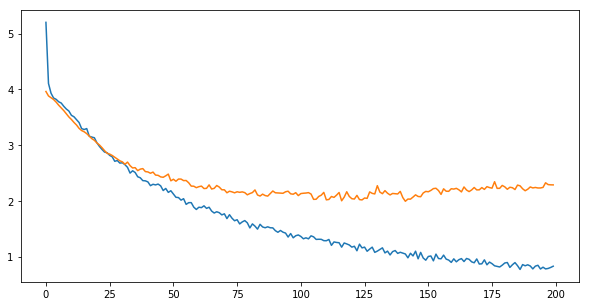

In [16]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

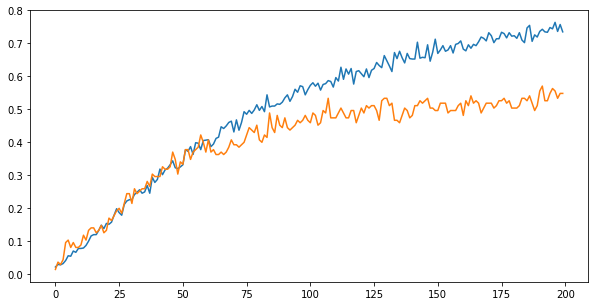

In [17]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.5530973451327433
Confusion matrix, without normalization
[[3 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 ...
 [0 0 0 ... 4 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 4]]


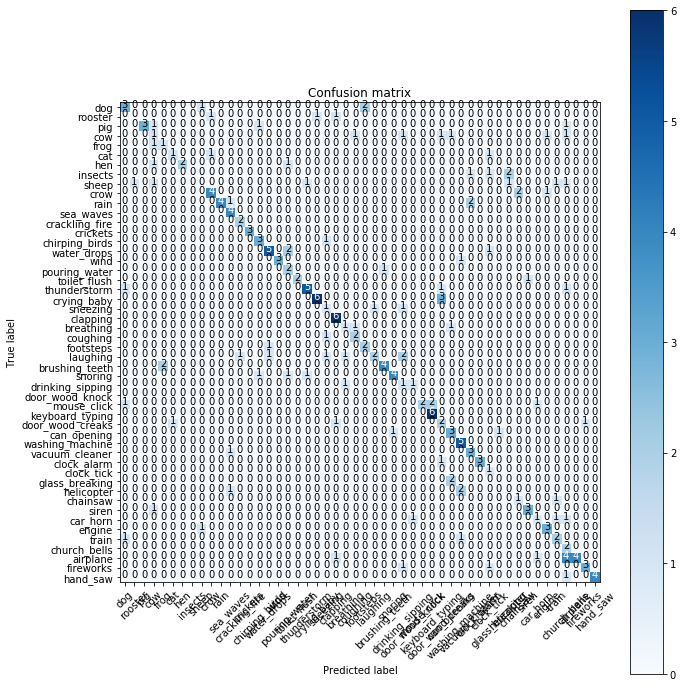

In [18]:
pred = anim.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes)
plt.show()

# All Data

In [19]:
all_df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        fld=range(2,6), 
                        blocksize=blocksize, 
                        overlap=overlap)

Preprocess file not found, building new one
Epoch 1/1
2/2 [==============================] - 0s 118ms/step - loss: 1.2490
Epoch 1/1
2/2 [==============================] - 0s 103ms/step - loss: 1.3326
	Bytes: 4211344
	Processing Time: 36.8429069519043


In [20]:
X = all_df.drop(['l_target', 'h_target'], axis=1)
y = all_df['h_target']

0.1773909211106214
Confusion matrix, without normalization
[[37  2  1 ...  0  8  0]
 [ 0 17  0 ...  0  0  0]
 [ 0  1  5 ...  0  1  1]
 ...
 [ 0  0  0 ... 16  0  0]
 [ 6  0  3 ...  0 10  0]
 [ 0  0  2 ...  0  0 22]]


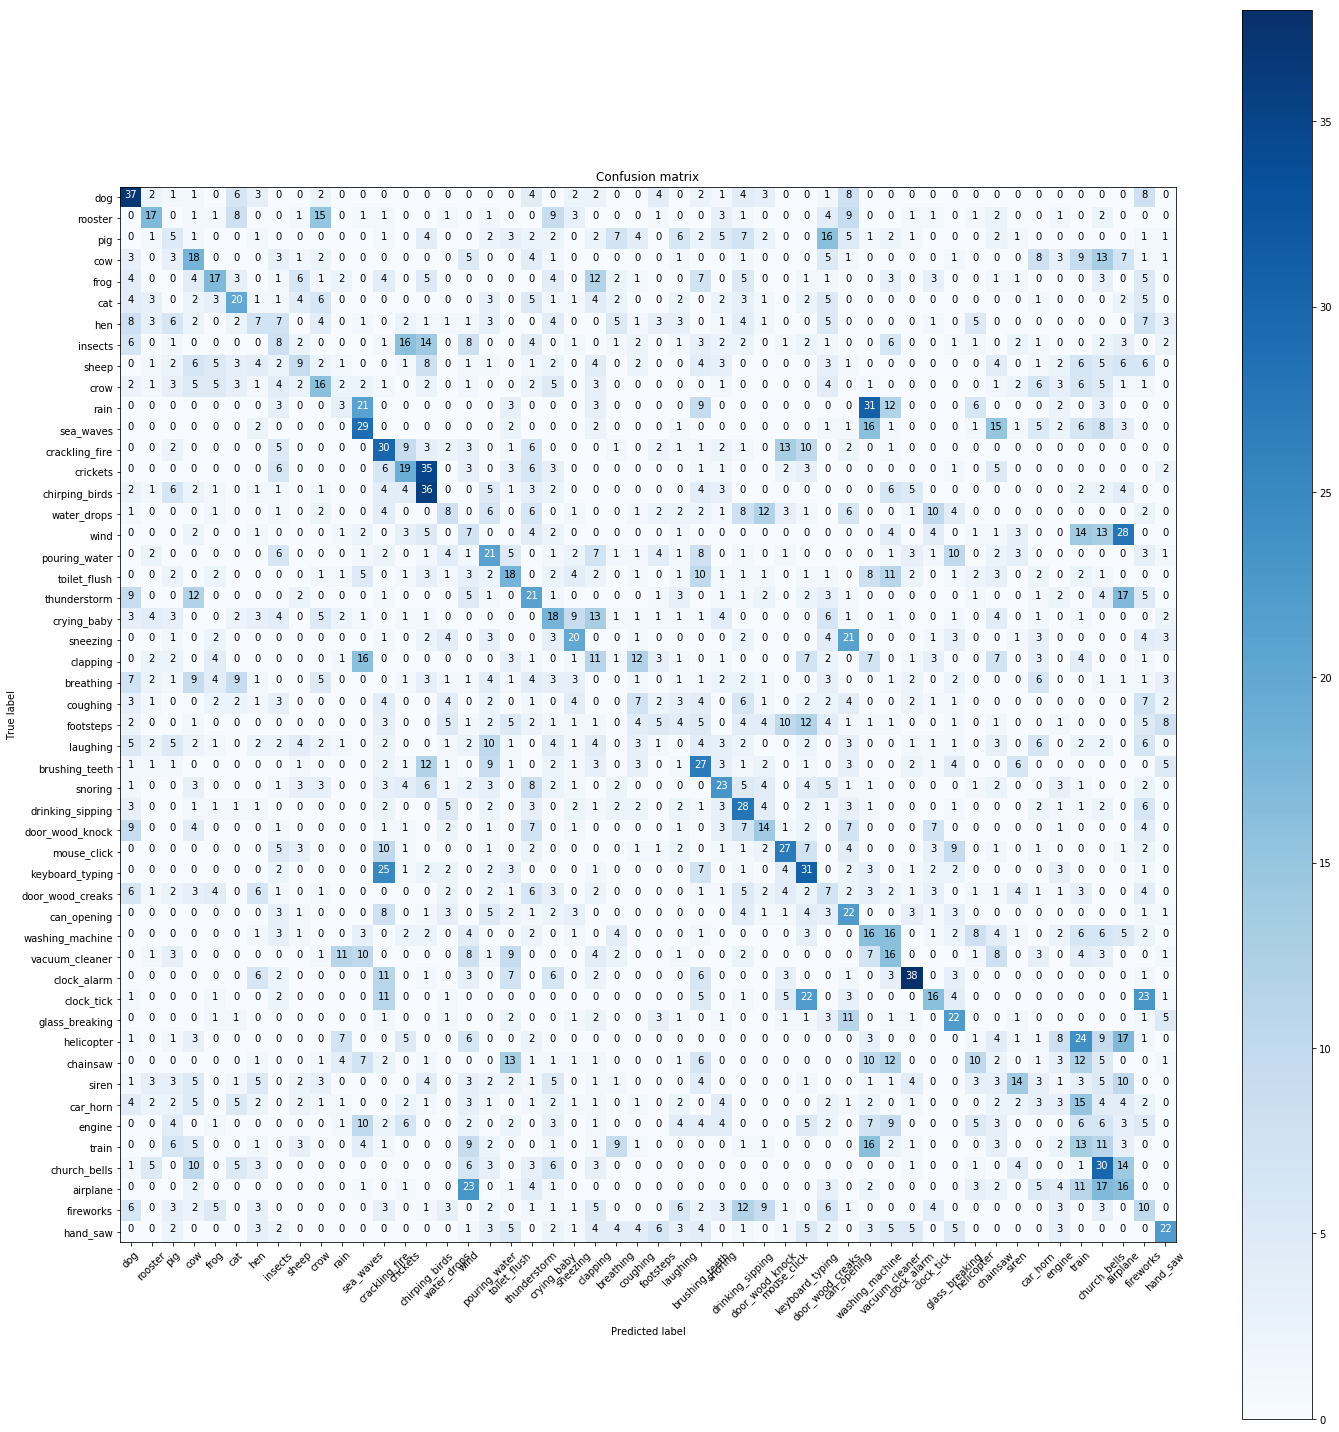

In [21]:
pred = anim.predict(X)
print(metrics.accuracy_score(y, pred))
cm = metrics.confusion_matrix(y, pred)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()